In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'
DS_LIST = ['facs', 'droplet']

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.gwas_max_abs_z.top500',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.gwas_max_abs_z.top500',
                  'facs_tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                  'droplet_tsig': DATA_PATH+'/score_file/score.tms_droplet_with_cov.tcell_sig'}
TRAIT_LIST = ['PASS_IBD', 'PASS_IBD_deLange2017', 'PASS_Multiple_sclerosis', 'PASS_Rheumatoid_Arthritis', 
              'PASS_AdultOnsetAsthma_Ferreira2019', 'UKB_460K.disease_ASTHMA_DIAGNOSED',
              'UKB_460K.blood_LYMPHOCYTE_COUNT', 'UKB_460K.disease_AID_ALL', 
              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_DERMATOLOGY', 
              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_RESPIRATORY_ENT']
DIC_TRAIT_NAME = {'PASS_IBD': 'IBD', 'PASS_IBD_deLange2017': 'IBD_deLange2017', 'PASS_Multiple_sclerosis': 'MS',
                  'PASS_Rheumatoid_Arthritis': 'RA', 'PASS_AdultOnsetAsthma_Ferreira2019':'ASTHMA_Ferreira2019', 
                  'UKB_460K.disease_ASTHMA_DIAGNOSED':'ASTHMA', 'UKB_460K.blood_LYMPHOCYTE_COUNT':'LYMPH_COUNT',
                  'UKB_460K.disease_AID_ALL':'AID', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED':'ECZEMA',
                  'UKB_460K.disease_DERMATOLOGY':'DERMATOLOGY', 
                  'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP':'HT', 
                  'UKB_460K.disease_RESPIRATORY_ENT':'RESPIRATORY_ENT'}

In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')

# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    print('# Loading %s score'%score)
    for file in [x for x in os.listdir(DIC_SCORE_PATH[score]) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        if (trait not in TRAIT_LIST) & (score in DS_LIST):
            continue
        temp_df = pd.read_csv(join(DIC_SCORE_PATH[score],file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_raw[ds].obs_names) & set(dic_score[ds].index))

Trying to set attribute `.obs` of view, copying.


# Loading facs score
# Loading droplet score
# Loading facs_tsig score
# Loading droplet_tsig score


facs


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
... storing 'tissue_celltype' as categorical


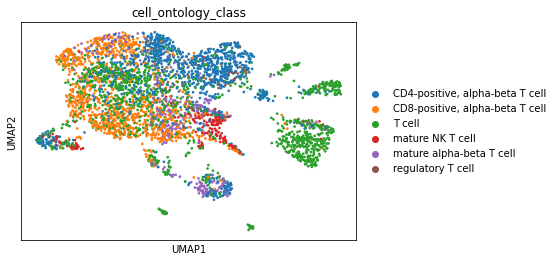

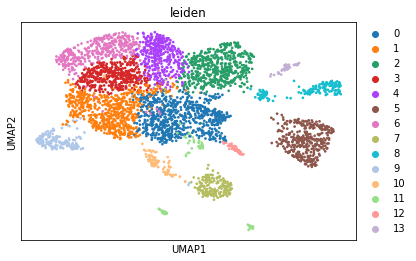

In [30]:
# # Reprocess t cell data
# dic_data_proc = {}
# for ds in DS_LIST:
#     print(ds)
# #     ind_select = [('thymocyte' in x) | ('T cell' in x)  for x in dic_data_raw[ds].obs['tissue_celltype']]
#     ind_select = [('T cell' in x)  for x in dic_data_raw[ds].obs['tissue_celltype']]
#     adata = dic_data_raw[ds][ind_select,:].copy()
#     sc.pp.filter_cells(adata, min_genes=250)
#     sc.pp.filter_genes(adata, min_cells=50)
#     adata.obs['batch_harmony'] = adata.obs['mouse.id']
#     adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

#     sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
#                                 min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
#     sc.pp.scale(adata, max_value=10, zero_center=False)
#     sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
#     sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     sc.tl.leiden(adata, resolution=0.7)   
#     sc.tl.umap(adata)
#     sc.pl.umap(adata, color='cell_ontology_class')
#     sc.pl.umap(adata, color='leiden')
#     adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
#                 'tcell.%s.h5ad'%ds)

In [36]:
dic_data_proc = {}
for ds in ['facs', 'droplet']:   
    dic_data_proc[ds] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                  'tms_proc/tcell.%s.h5ad'%ds)

In [6]:
# Load control score 
dic_ctrl_score = {}
for score in ['facs', 'facs_tsig']:
    dic_ctrl_score[score] = {}
    for file in [x for x in os.listdir(DIC_SCORE_PATH[score]) if '.full_score.gz' in x]:
        trait = file.replace('.full_score.gz','')
        if (trait not in TRAIT_LIST) & (score in DS_LIST):
            continue
        if ('_vs_' in trait) & ('_tsig' in score):
            continue
        print('# Loading %s %s'%(score, trait))
        temp_df = pd.read_csv(join(DIC_SCORE_PATH[score],file), sep='\t', index_col=0)
        temp_df = temp_df.loc[set(dic_data_proc['facs'].obs_names) & set(temp_df.index)]
        dic_ctrl_score[score][trait] = temp_df.copy()

# Loading facs PASS_Rheumatoid_Arthritis
# Loading facs UKB_460K.disease_RESPIRATORY_ENT
# Loading facs UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading facs UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading facs PASS_Multiple_sclerosis
# Loading facs UKB_460K.disease_AID_ALL
# Loading facs UKB_460K.blood_LYMPHOCYTE_COUNT
# Loading facs PASS_AdultOnsetAsthma_Ferreira2019
# Loading facs PASS_IBD
# Loading facs UKB_460K.disease_DERMATOLOGY
# Loading facs UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading facs PASS_IBD_deLange2017
# Loading facs_tsig memory_cd8_singer
# Loading facs_tsig naive_cd4
# Loading facs_tsig reg_cd4
# Loading facs_tsig memory_cd4
# Loading facs_tsig effector_cd4
# Loading facs_tsig effector_cd8_singer
# Loading facs_tsig effector_cd8
# Loading facs_tsig naive_cd8
# Loading facs_tsig naive_cd8_singer
# Loading facs_tsig memory_cd8


### Annotate FACS data

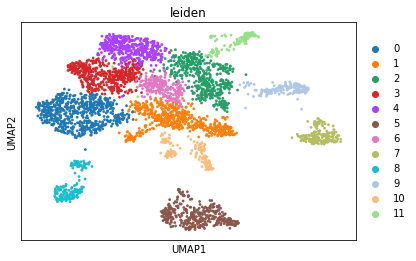

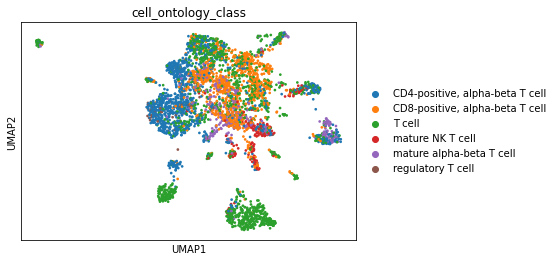

In [37]:
# Annotate FACS data 
adata = dic_data_proc['facs'].copy()
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
sc.pl.umap(adata[adata.obs['leiden'].isin(cluster_list)], color='leiden')
# sc.pl.umap(adata, color='tissue')
sc.pl.umap(adata, color='cell_ontology_class')

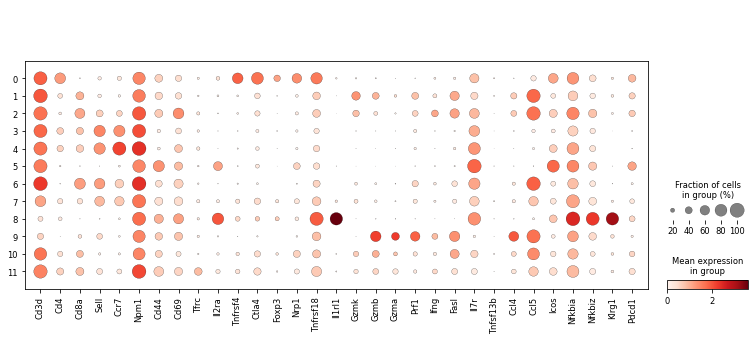

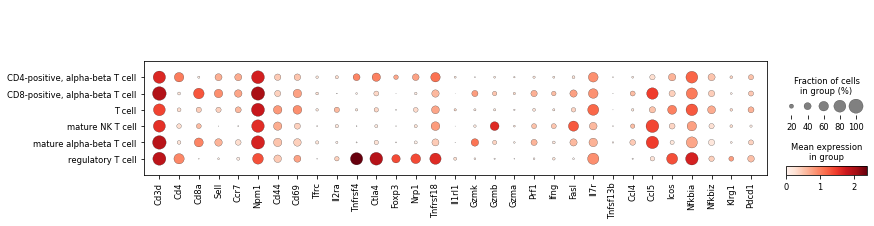

cell
leiden cell_ontology_class                   
0      CD4-positive, alpha-beta T cell  486.0
       T cell                            74.0
       regulatory T cell                 41.0
1      CD4-positive, alpha-beta T cell   52.0
       CD8-positive, alpha-beta T cell  211.0
       T cell                            71.0
       mature NK T cell                  78.0
       mature alpha-beta T cell         147.0
2      CD4-positive, alpha-beta T cell   30.0
       CD8-positive, alpha-beta T cell  310.0
       T cell                           159.0
3      CD4-positive, alpha-beta T cell  236.0
       CD8-positive, alpha-beta T cell  158.0
       T cell                            53.0
       mature alpha-beta T cell          36.0
4      CD4-positive, alpha-beta T cell  126.0
       CD8-positive, alpha-beta T cell   81.0
       T cell                           195.0
5      T cell                           340.0
6      CD8-positive, alpha-beta T cell  165.0
       T cell                            46.0
       mature alpha-beta T cell          28.0
7      CD4-positive, alpha-beta T cell   64.0
       T cell                            29.0
       mature alpha-beta T cell          75.0
8      CD4-positive, alpha-beta T cell   48.0
       T cell                           113.0
9      CD4-positive, alpha-beta T cell   62.0
       T cell                            47.0
       mature NK T cell                  38.0
10     CD8-positive, alpha-beta T cell   31.0
       mature NK T cell                  58.0
11     CD8-positive, alpha-beta T cell   26.0
       T cell                            57.0

In [8]:
# Marker genes 
adata = dic_data_proc['facs'].copy()
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
adata = adata[adata.obs['leiden'].isin(cluster_list)]
marker_list = ['Cd3d', 'Cd4', 'Cd8a', # Basic
               'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
               'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'Ctla4', 'Foxp3', 'Nrp1', 'Tnfrsf18', 'Il1rl1', # Treg
               'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
               'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
               'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]

for gene in marker_list.copy():
    if gene not in adata.var_names:
        print(gene)
        marker_list.remove(gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden')
sc.pl.dotplot(adata, marker_list, groupby='cell_ontology_class')


temp_df = adata.obs.groupby(['leiden', 'cell_ontology_class']).agg({'cell':len})
display(temp_df.loc[temp_df['cell']>25])

Trying to set attribute `.uns` of view, copying.


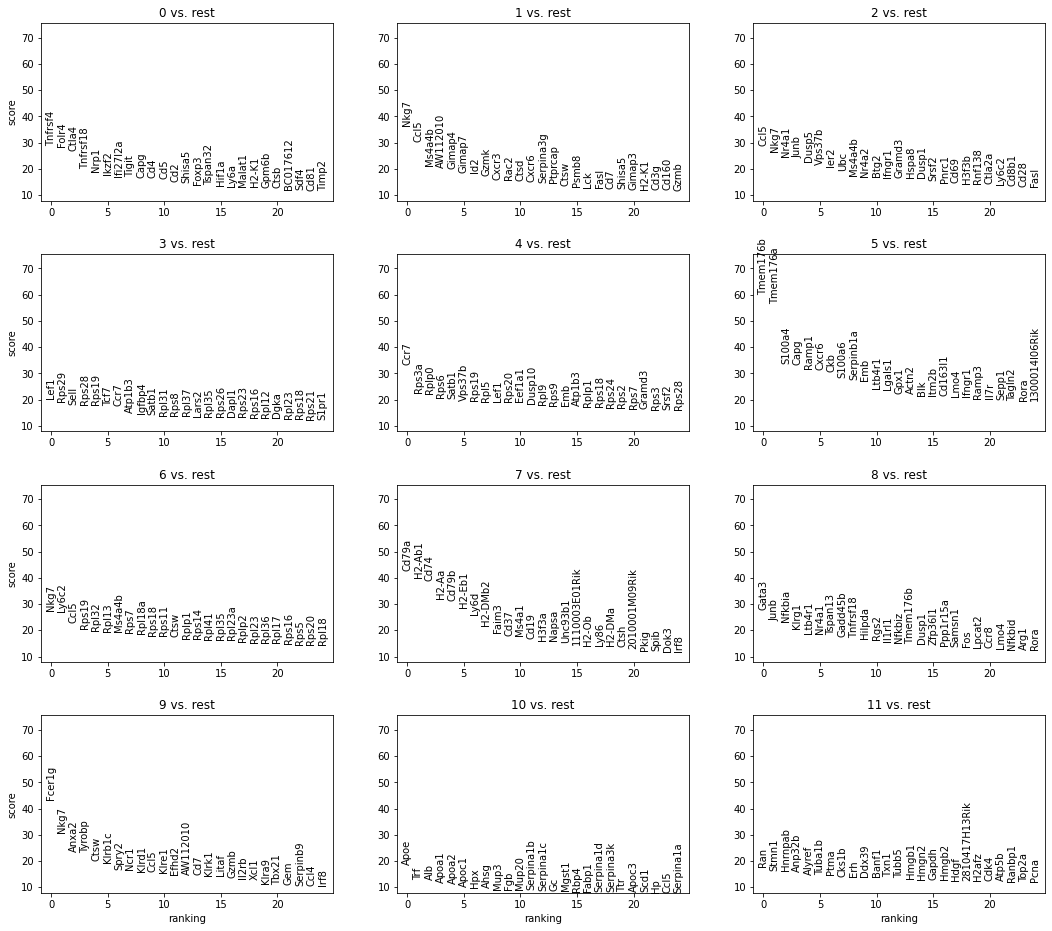

In [9]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=3, n_genes=25)

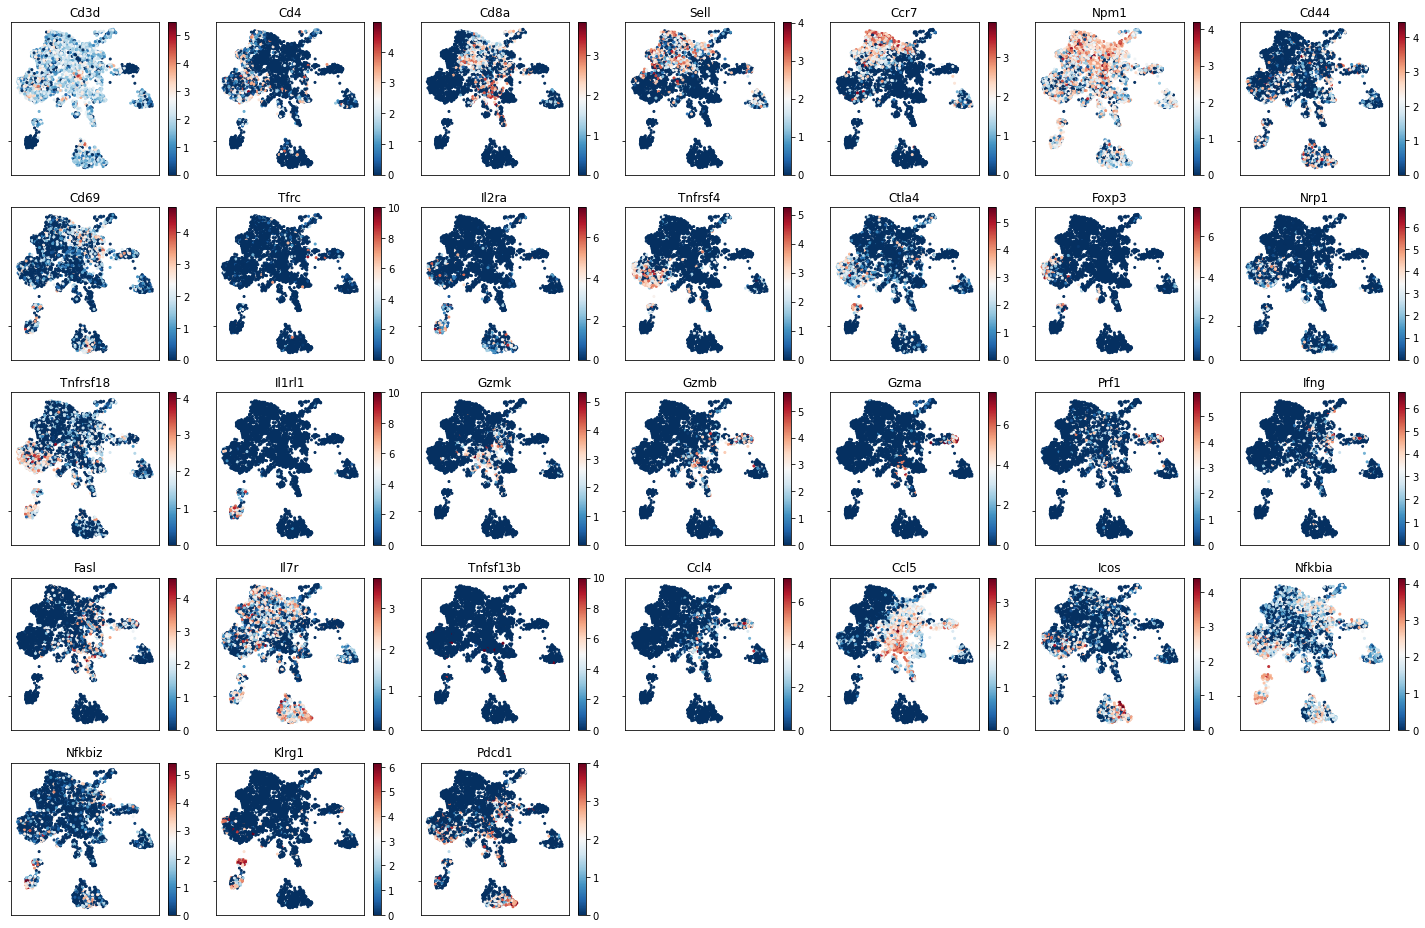

In [10]:
# Marker genes 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
for gene in marker_list:
    df_plot[gene] = adata[:, gene].X.toarray()

plt.figure(figsize=[20,13])
for igene,gene in enumerate(marker_list):
    plt.subplot(5,7,igene+1)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='RdBu_r', s=4)
    plt.colorbar()
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([0],[''])
    plt.yticks([0],[''])
    plt.title(gene)

plt.tight_layout()
plt.show()

In [11]:
np.where(np.array([x[8] for x in adata.uns['rank_genes_groups']['names']])=='Icos')

(array([1364]),)

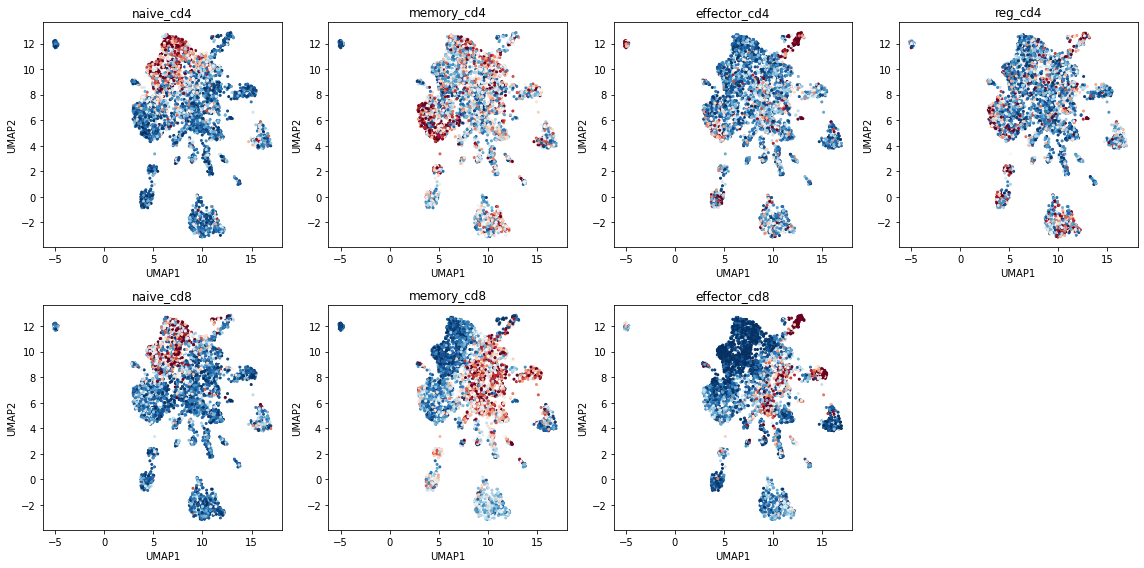

In [12]:
adata = dic_data_proc['facs'].copy()
trait_list_plot = sorted([x.replace('.raw_score','') for x in dic_score['facs_tsig'].columns if 'raw_score' in x])
trait_list_plot = ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4',
                   'naive_cd8', 'memory_cd8', 'effector_cd8']
ds = 'facs'
score_name = 'facs_tsig'
nrow,ncol =2,4

plt.figure(figsize=[16, 8])
for i_trait,trait in enumerate(trait_list_plot):
    plt.subplot(nrow,ncol,i_trait+1)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
    df_plot = df_plot.loc[list(set(df_plot.index) & set(dic_score[score_name].index))]
    df_plot = df_plot.join(dic_score[score_name]['%s.nlog10_pval'%trait])

    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                cmap='RdBu_r', vmax=np.quantile(df_plot['%s.nlog10_pval'%trait], q=0.95), vmin=0, s=4)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(trait)

plt.tight_layout()
plt.show()

Trying to set attribute `.obs` of view, copying.


# Before filter: n_cell=4145
# After filter: n_cell=3769


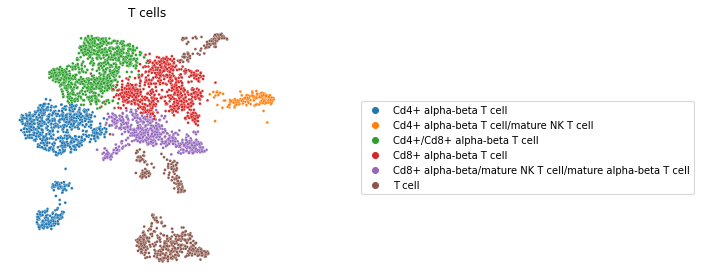

In [63]:
# Trajectory for facs data 
# Maybe a more refined annotation later 
adata = dic_data_proc['facs'].copy()
dic_annot = {'0': 'Cd4+ alpha-beta T cell', # Tnfrsf4 (OX40, effector), Ctla,Foxp3 (Treg)
             '1': 'Cd8+ alpha-beta T cell/mature NK T cell/mature alpha-beta T cell', # Effector Cd8 
             '2': 'Cd8+ alpha-beta T cell', # Effector Cd8
             '3': 'Cd4+/Cd8+ alpha-beta T cell', # Clearly naive 
             '4': 'Cd4+/Cd8+ alpha-beta T cell', # Clearly naive 
             '5': 'T cell', # Cd4- Cd8-, may not be typical T cells
             '6': 'Cd8+ alpha-beta T cell', # Effector Cd8, does seem to be functioning yet
             '7': 'rm', # Contains B cells and macrophage markers, suspicious
             '8': 'Cd4+ alpha-beta T cell', # Klrg1 is related to apoptosis
             '9': 'Cd4+ alpha-beta T cell/mature NK T cell', 
             '10': 'T cell', # Apoe is weird
             '11': 'T cell', # 
            }

adata.obs['leiden_anno'] = [dic_annot[x] if x in dic_annot else 'na' for x in adata.obs['leiden']]

# Remove irrelevant clusters 
print('# Before filter: n_cell=%d'%adata.shape[0])
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
adata = adata[adata.obs['leiden'].isin(cluster_list)]
adata = adata[adata.obs['leiden_anno']!='rm']
adata.obs['leiden_anno'] = adata.obs['leiden_anno'].astype('category')
print('# After filter: n_cell=%d'%adata.shape[0])

# Figure 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs['leiden_anno'])

plt.figure(figsize=[11,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
# g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden_anno', s=4)
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden_anno', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('T cells')
plt.tight_layout()
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.png')
plt.show()

Trying to set attribute `.obs` of view, copying.


# Before filter: n_cell=4145
# After filter: n_cell=3769


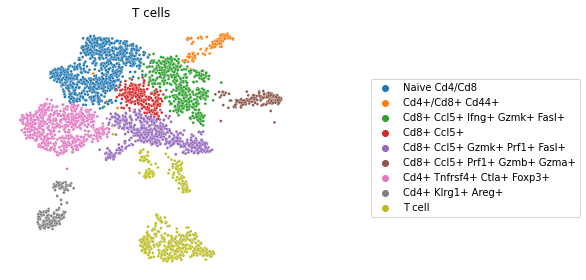

In [38]:
# # Trajectory for facs data 
# # Maybe a more refined annotation later 
# adata = dic_data_proc['facs'].copy()
# dic_annot = {'0': 'Cd4+ Tnfrsf4+ Ctla+ Foxp3+', # Tnfrsf4 (OX40, effector), Ctla,Foxp3 (Treg)
#              '1': 'Cd8+ Ccl5+ Gzmk+ Prf1+ Fasl+', # Effector Cd8 
#              '2': 'Cd8+ Ccl5+ Ifng+ Gzmk+ Fasl+', # Effector Cd8
#              '3': 'Naive Cd4/Cd8', # Clearly naive 
#              '4': 'Naive Cd4/Cd8', # Clearly naive 
#              '5': 'T cell', # Cd4- Cd8-, may not be typical T cells
#              '6': 'Cd8+ Ccl5+', # Effector Cd8, does seem to be functioning yet
#              '7': 'rm', # Contains B cells and macrophage markers, suspicious
#              '8': 'Cd4+ Klrg1+ Areg+', # Klrg1 is related to apoptosis
#              '9': 'Cd8+ Ccl5+ Prf1+ Gzmb+ Gzma+', 
#              '10': 'T cell', # Apoe is weird
#              '11': 'Cd4+/Cd8+ Cd44+', # 
#             }

# adata.obs['leiden_anno'] = [dic_annot[x] if x in dic_annot else 'na' for x in adata.obs['leiden']]

# # Remove irrelevant clusters 
# print('# Before filter: n_cell=%d'%adata.shape[0])
# temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
# cluster_list = list(temp_df.index[temp_df['cell']>100])
# adata = adata[adata.obs['leiden'].isin(cluster_list)]
# adata = adata[adata.obs['leiden_anno']!='rm']
# adata.obs['leiden_anno'] = adata.obs['leiden_anno'].astype('category')
# print('# After filter: n_cell=%d'%adata.shape[0])

# # Figure 
# df_plot = pd.DataFrame(index=adata.obs_names,
#                        data={'UMAP1':adata.obsm['X_umap'][:,0],
#                              'UMAP2':adata.obsm['X_umap'][:,1]})
# df_plot = df_plot.join(adata.obs['leiden_anno'])

# plt.figure(figsize=[9,4])
# ax = plt.subplot(1,1,1)
# ax.axis('off')
# # g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden_anno', s=4)
# g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden_anno', s=8,
#                     hue_order=['Naive Cd4/Cd8', 
#                                'Cd4+/Cd8+ Cd44+', 
#                                'Cd8+ Ccl5+ Ifng+ Gzmk+ Fasl+', 
#                                'Cd8+ Ccl5+', 
#                                'Cd8+ Ccl5+ Gzmk+ Prf1+ Fasl+', 
#                                'Cd8+ Ccl5+ Prf1+ Gzmb+ Gzma+',
#                                'Cd4+ Tnfrsf4+ Ctla+ Foxp3+', 
#                                'Cd4+ Klrg1+ Areg+',
#                                'T cell'])
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# plt.title('T cells')
# plt.tight_layout()
# plt.savefig(FIG_PATH+'/tcell_umap.svg')
# plt.savefig(FIG_PATH+'/tcell_umap.png')
# plt.show()

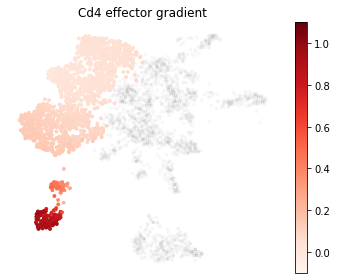

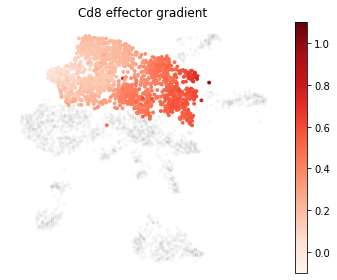

In [65]:
sc.tl.diffmap(adata)
# root_cell = adata.obs_names[np.argmin(adata.obsm['X_umap'][:,0]+100*(adata.obs['leiden_anno']!='Naive Cd4/Cd8'))]
root_cell = adata.obs_names[np.argmin(adata.obsm['X_umap'][:,0]+100*(adata.obs['leiden_anno']!='Cd4+/Cd8+ alpha-beta T cell'))]

# Cd4 trajectory 
# cluster_list = ['Naive Cd4/Cd8', 'Cd4+ Tnfrsf4+ Ctla+ Foxp3+', 'Cd4+ Klrg1+ Areg+', 'Cd4+/Cd8+ Cd44+']
cluster_list = ['Cd4+ alpha-beta T cell', 'Cd4+/Cd8+ alpha-beta T cell']
temp_data = adata[adata.obs['leiden_anno'].isin(cluster_list), :].copy()
temp_data.uns['iroot'] = np.where(temp_data.obs_names==root_cell)[0][0]
sc.tl.dpt(temp_data)
adata.obs['dpt_cd4'] = 0
adata.obs.loc[temp_data.obs_names, 'dpt_cd4'] = temp_data.obs['dpt_pseudotime']

# Cd8 trajectory
# cluster_list = ['Naive Cd4/Cd8', 'Cd4+/Cd8+ Cd44+', 'Cd8+ Ccl5+ Ifng+ Gzmk+ Fasl+', 'Cd8+ Ccl5+', 
#                 'Cd8+ Ccl5+ Gzmk+ Prf1+ Fasl+', 'Cd8+ Ccl5+ Prf1+ Gzmb+ Gzma+']
cluster_list = ['Cd4+/Cd8+ alpha-beta T cell', 'Cd8+ alpha-beta T cell', 
                'Cd8+ alpha-beta T cell/mature NK T cell/mature alpha-beta T cell']
temp_data = adata[adata.obs['leiden_anno'].isin(cluster_list), :].copy()
temp_data.uns['iroot'] = np.where(temp_data.obs_names==root_cell)[0][0]
sc.tl.dpt(temp_data)
adata.obs['dpt_cd8'] = 0
adata.obs.loc[temp_data.obs_names, 'dpt_cd8'] = temp_data.obs['dpt_pseudotime']

# Pseudotime: make it nicer later 
dic_title = {'dpt_cd4': 'Cd4 effector gradient', 
             'dpt_cd8': 'Cd8 effector gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4', 'dpt_cd8']])

for term in ['dpt_cd4', 'dpt_cd8']:
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>0
#     ind_select_
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
#     plt.scatter([temp_data.obsm['X_umap'][1734,0]], [temp_data.obsm['X_umap'][1734,1]])
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/%s.svg'%term)
    plt.savefig(FIG_PATH+'/%s.png'%term)
    plt.show()

In [66]:
adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
            'tcell.facs.annot.h5ad')

### Correlating with DPT

In [67]:
dic_data_traj = {}
dic_data_traj['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'tcell.facs.annot.h5ad')

In [68]:
# Compute p-value
adata = dic_data_traj['facs'].copy()
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'CORR', 'P'])

for dpt in ['dpt_cd4', 'dpt_cd8']:
    for trait in TRAIT_LIST:
        df_plot = adata.obs[[dpt]].copy()
        df_plot = df_plot.loc[df_plot[dpt]>0]
        df_plot = df_plot.join(dic_score['facs'].loc[adata.obs_names, ['%s.norm_score'%trait]])
        df_plot = df_plot.join(dic_ctrl_score['facs'][trait])
        corr_ = sp.stats.spearmanr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
        v_corr_ = np.zeros(500)
        for i in range(500):
            v_corr_[i] = sp.stats.spearmanr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
        p_ = ((np.absolute(corr_) <= np.absolute(v_corr_)).sum()+1) / 501
        df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]

temp_list = sorted([x.replace('.raw_score','') for x in dic_score['facs_tsig'].columns 
                    if ('raw_score' in x) & ('_vs_' not in x)])
for dpt in ['dpt_cd4', 'dpt_cd8']:
    for trait in temp_list:
        df_plot = adata.obs[[dpt]].copy()
        df_plot = df_plot.loc[df_plot[dpt]>0]
        df_plot = df_plot.join(dic_score['facs_tsig'].loc[adata.obs_names, ['%s.norm_score'%trait]])
        df_plot = df_plot.join(dic_ctrl_score['facs_tsig'][trait])
        corr_ = sp.stats.spearmanr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
        v_corr_ = np.zeros(500)
        for i in range(500):
            v_corr_[i] = sp.stats.spearmanr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
        p_ = ((np.absolute(corr_) <= np.absolute(v_corr_)).sum()+1) / 501
        df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]

In [69]:
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]

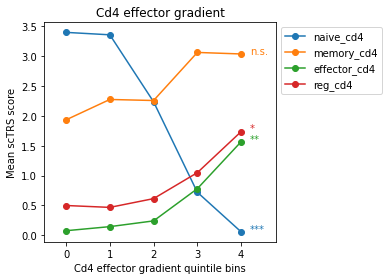

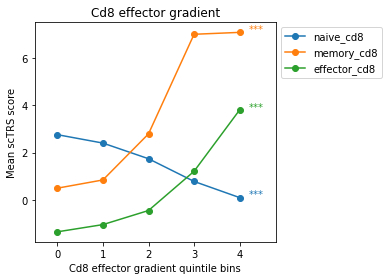

In [70]:
# T signatures
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted([x.replace('.raw_score','') for x in dic_score['facs_tsig'].columns if 'raw_score' in x])

plot_list = [['dpt_cd4', ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4']],
             ['dpt_cd8', ['naive_cd8', 'memory_cd8', 'effector_cd8']], 
            ]

ds = 'facs_tsig'
dic_title = {'dpt_cd4': 'Cd4 effector gradient', 
             'dpt_cd8': 'Cd8 effector gradient'}
nrow,ncol =2,4
for i_plot,temp_list in enumerate(plot_list):
    term,sig_list = temp_list
    df_plot = adata.obs[[term]].copy()
    df_plot = df_plot.loc[df_plot[term]>0]
    df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, ['%s.norm_score'%x for x in sig_list]])
    df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
    
    plt.figure(figsize=[5.5,4])
    i_color = 0
    for sig in sig_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%sig: [np.mean, np.std]})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%sig]['mean'], 'o-', label=sig, color='C%d'%i_color)
        plt.text(4.2, temp_df['%s.norm_score'%sig]['mean'][4], df_stats.loc['%s.%s'%(term,sig),'P_STR'],
                 color='C%d'%i_color)
        i_color+=1
    
    plt.xlim([-0.5,4.8])
    plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.ylabel('Mean scTRS score')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%term)
    plt.show()

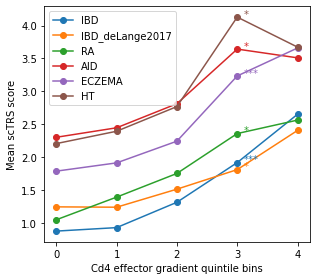

In [71]:
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted(TRAIT_LIST)
ds = 'facs'


for term in ['dpt_cd4']:
    i_color = 0
    plt.figure(figsize=[4.5,4])
    for i_trait,trait in enumerate(trait_list_plot):
        
        if df_stats.loc['%s.%s'%(term,trait),'P']<0.05:
            df_plot = adata.obs[[term, 'cell_ontology_class']].copy()
            df_plot = df_plot.loc[df_plot[term]>0]
            df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
            df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.norm_score'%trait])
            
            temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
            temp_df.columns = ['mean']
        
            plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DIC_TRAIT_NAME[trait], color='C%d'%i_color)
            plt.text(3.1, temp_df['mean'][3], df_stats.loc['%s.%s'%(term,trait),'P_STR'], color='C%d'%i_color)
            i_color += 1
        
    plt.xlim([-0.2,4.2])
    plt.ylabel('Mean scTRS score')
    plt.xlabel('%s quintile bins'%dic_title[term])
#     plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.legend()
#     plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%term)
    plt.show()

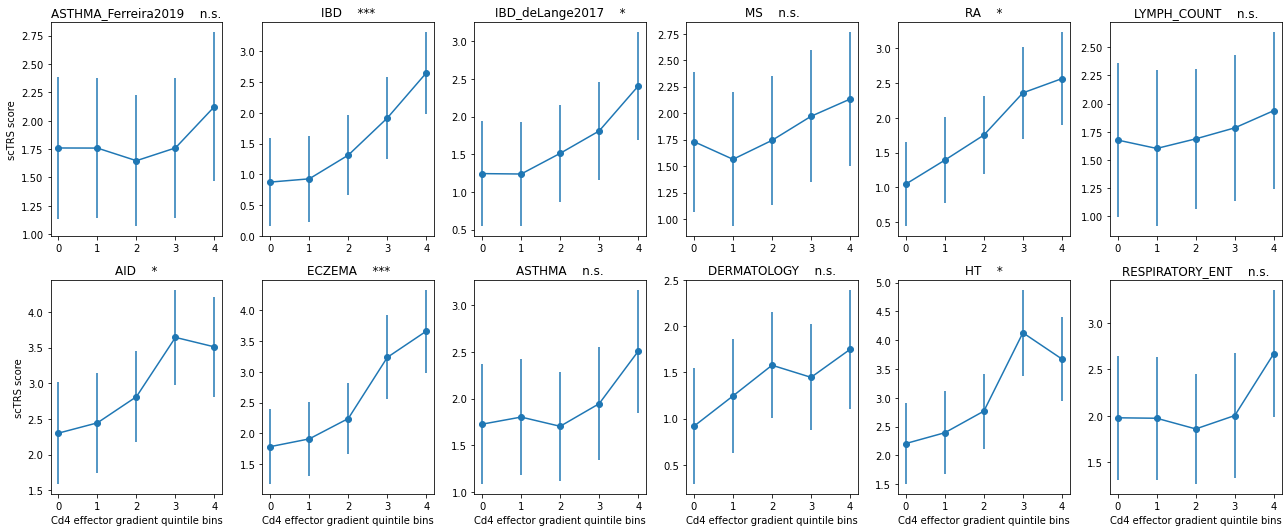

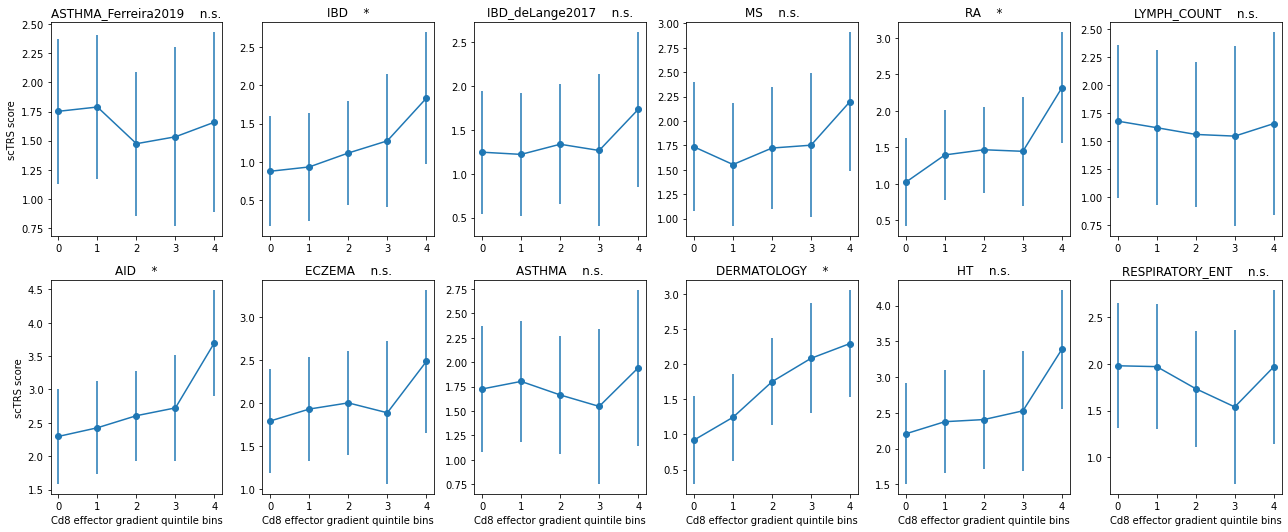

In [72]:
adata = dic_data_traj['facs'].copy()
trait_list_plot = sorted(TRAIT_LIST)
ds = 'facs'
nrow,ncol =2,6
for term in ['dpt_cd4', 'dpt_cd8']:
    plt.figure(figsize=[18, 7.5])
    for i_trait,trait in enumerate(trait_list_plot):
        plt.subplot(nrow,ncol,i_trait+1)
        
        df_plot = adata.obs[[term, 'cell_ontology_class']].copy()
        df_plot = df_plot.loc[df_plot[term]>0]
        df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
        df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.norm_score'%trait])
        df_plot = df_plot.join(dic_ctrl_score[ds][trait])
        
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        temp_df.columns = ['mean']
        temp_df_std = df_plot.groupby('bin').agg({'ctrl_norm_score_%d'%x: np.mean for x in range(500)}).std(axis=1)
        temp_df['std'] = temp_df_std.loc[temp_df.index].values
        
        plt.errorbar(temp_df.index, temp_df['mean'], yerr = temp_df['std']*1.96, fmt='-o', 
                     label=trait.replace('PASS_','').replace('UKB_460K.disease_',''))
        plt.title(DIC_TRAIT_NAME[trait]+'    ' + df_stats.loc['%s.%s'%(term,trait),'P_STR'])
        if i_trait>=ncol:
            plt.xlabel('%s quintile bins'%dic_title[term])
        else:
            plt.xlabel('')
        if i_trait%ncol==0:
            plt.ylabel('scTRS score')
        else:
            plt.ylabel('')
        
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr_all.%s.svg'%term)
    plt.show()

### Prioritize gene sets 

In [48]:
df_gs_gwas = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs',
                         sep='\t', index_col=0)
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                             'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [55]:
# GWAS and scTRS gene sets 
dic_gs = {}
temp_adata = dic_data_raw['facs'][dic_data_traj['facs'].obs_names, list(background_set)].copy()

for trait in TRAIT_LIST:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
#     temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.zscore'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])

In [56]:
# Gold standard gene sets 
dic_ref = {'PASS_IBD': 'Fang_NG_2019:UC.drug_target;Fang_NG_2019:CRO.drug_target',
           'PASS_Multiple_sclerosis': 'Fang_NG_2019:MS.drug_target',
           'PASS_Rheumatoid_Arthritis': 'Fang_NG_2019:RA.drug_target',
           'PASS_AdultOnsetAsthma_Ferreira2019': 'Fang_NG_2019:ASM.drug_target',
           'UKB_460K.disease_ASTHMA_DIAGNOSED': 'Fang_NG_2019:ASM.drug_target',
           'UKB_460K.disease_AID_ALL': 'Freund_AJHG_2018:Immune_Dysregulation',
           'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': 'Fang_NG_2019:ALG.drug_target',
           'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': 'Freund_AJHG_2018:Immune_Dysregulation',
           'UKB_460K.disease_RESPIRATORY_ENT': 'Fang_NG_2019:ASM.drug_target'
            }
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Fang_NG_2019', 'Freund_AJHG_2018']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [57]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

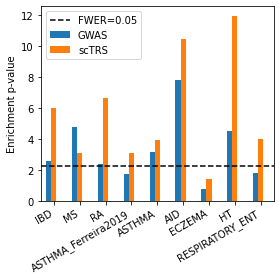

In [58]:
dic_config = {'gwas': ['C0', 'GWAS'], 
              'sctrs': ['C1', 'scTRS']}

df_plot = dic_stats[res][['GS']].copy()
for res in ['gwas', 'sctrs']:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
#     df_plot['%s.or'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio']
#     df_plot['%s.or_lb'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.lb']
#     df_plot['%s.or_ub'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.ub']
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])


plt.figure(figsize=[4, 4])
for i_res,res in enumerate(['gwas', 'sctrs']):
    mat_xerr = np
    plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
            width=0.2, color=dic_config[res][0], label=dic_config[res][1])

fwer_thres = -np.log10(0.05/df_plot.shape[0])
plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
         label='FWER=0.05')

plt.legend()
plt.xticks(df_plot['loc'], [DIC_TRAIT_NAME[x] for x in df_plot.index], rotation=30, ha='right')
plt.ylabel('Enrichment p-value')
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs.svg')
plt.show()

In [164]:

for trait in dic_ref:
    print(trait)
    pval,_,_,_ = util.test_overlap(dic_gs['%s.ref'%trait], dic_gs['%s.gwas'%trait], adata.var_names)
    print('gwas p=%0.2e    overlap=%d    genes:%s'
          %(pval, len(dic_gs['%s.ref'%trait]&dic_gs['%s.gwas'%trait]), 
            ','.join(dic_gs['%s.ref'%trait]&dic_gs['%s.gwas'%trait])))
    
    pval,_,_,_ = util.test_overlap(dic_gs['%s.ref'%trait], dic_gs['%s.sctrs'%trait], adata.var_names)
    print('sctrs p=%0.2e    overlap=%d    genes:%s'
          %(pval, len(dic_gs['%s.ref'%trait]&dic_gs['%s.sctrs'%trait]), 
            ','.join(dic_gs['%s.ref'%trait]&dic_gs['%s.sctrs'%trait])))
    print('')

PASS_IBD
gwas p=8.92e-03    overlap=6    genes:Cxcr2,Pde4a,Itgb1,Jak1,S1pr5,Il12b
sctrs p=6.97e-05    overlap=9    genes:Igf1r,Nr3c1,Il17a,Alox5,Il2ra,Itgb1,Il2rb,Il2rg,Itgb7

PASS_Multiple_sclerosis
gwas p=1.48e-04    overlap=9    genes:Oprm1,Cd80,Keap1,Il2ra,Oprk1,S1pr5,Il12a,Cd86,Il12b
sctrs p=3.86e-03    overlap=7    genes:Nr3c1,Il2ra,Itgb1,Ccr2,Il2rb,Itga4,Itgb7

PASS_Rheumatoid_Arthritis
gwas p=1.28e-02    overlap=6    genes:Il6ra,Ptgs2,Ccr5,Pde4a,Kit,Tyk2
sctrs p=3.12e-06    overlap=11    genes:Jak2,Nr3c1,Itgav,Jak3,Itgb1,Pde4b,Il1r1,Tnfsf11,Itga4,Cd4,Itgb7

PASS_AdultOnsetAsthma_Ferreira2019
gwas p=5.21e-02    overlap=5    genes:Il13,Adora1,Chrm3,Il4ra,Il6
sctrs p=1.51e-01    overlap=4    genes:Nr3c1,Ltb4r1,Alox5,Il4ra

UKB_460K.disease_ASTHMA_DIAGNOSED
gwas p=3.57e-03    overlap=7    genes:Adora3,Cd80,Il13,Adora1,Il4ra,Il5,Il6
sctrs p=1.51e-02    overlap=6    genes:Ltb4r1,Nr3c1,Alox5,Il4ra,Pde4b,Mapk14

UKB_460K.disease_AID_ALL
gwas p=1.16e-05    overlap=40    genes:Rac2,Rad50

In [ ]:
 plt.figure(figsize=[6, 2+0.5*df_plot.shape[0]])
    for i_res,res in enumerate(res_list):
        plt.barh(df_plot['loc']-0.2*i_res+0.2, df_plot[res], 
                 height=0.2, color=dic_config[res][0], 
                 label=res+'(%0.2f$ \pm$%0.2f)'%(df_plot[res].mean(),
                                                 1.96*df_plot[res].std()/np.sqrt(df_plot.shape[0])))
    plt.legend()
    plt.yticks(df_plot['loc'], [x.split(':')[0] for x in df_plot.index])
    plt.xlabel('-log10 p-value')
    plt.ylim([-0.5, df_plot.shape[0]-0.5])
    plt.title(term)
    plt.show()
#     break